In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from torch.distributions import MultivariateNormal

In [2]:
class score_nn(torch.nn.Module):
    def __init__(self, x_dim, hidden_dim):
        super(score_nn, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        
        self.activation = nn.ELU()
        
        self.layer_input = nn.Linear(self.x_dim + 1, self.hidden_dim, bias=True)
        self.layer_1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layerout = nn.Linear(self.hidden_dim, x_dim-1, bias=True)
                
    def forward(self, x,t):
        z_in = torch.concat((x,t),dim=2)
        h = self.layer_input(z_in)
        h_temp = self.activation(self.layer_1(h)) 
        h_temp = self.activation(self.layer_2(h_temp)) 
        h = h_temp + h 
        z_out = self.layerout(h) 
        return z_out

In [4]:
N = 2000 # number of samples
T = 100  # number of time steps
n = 2 # system dimension
m = 1 # control dimension

tf = 1.0 # time horizon
dt = tf/T # time step

n_sigma = 1 # noise level

w = 0.5 # frequency

A = torch.tensor([[0.0, w],[-w, 0.0]])
B = torch.tensor([[0.0],[1.0]])

In [5]:
x_0 = MultivariateNormal(torch.zeros(n), torch.eye(n)).sample((N,))
y = torch.zeros((N,n))
y[:int(N/2)] = MultivariateNormal(torch.tensor([3.0,3.0]), torch.eye(n)).sample((int(N/2),))
y[int(N/2):] = MultivariateNormal(torch.tensor([-3.0,-3.0]), torch.eye(n)).sample((N//2,))

In [6]:
X_f = torch.zeros((T, N, n))
W_f = torch.zeros((T, N, m))


X_f[0] = x_0

t_N = torch.linspace(0.0, tf, T).repeat(N,1).reshape(N,T,1).permute(1,0,2) # shape (T,N,1)

In [8]:
def generate_phit(t, n, w):
    """
    t shape is (T, N, 1), output shape is (T, N, n, n)
    """
    T, N, _ = t.shape
    phi_t = torch.zeros((T, N, n, n))
    phi_t[:,:,0,0] = t[:,:,0]/2 - torch.sin(2*w*t[:,:,0])/(4*w)
    phi_t[:,:,0,1] = torch.sin(w*t[:,:,0])**2/(2*w)
    phi_t[:,:,1,0] = torch.sin(w*t[:,:,0])**2/(2*w)
    phi_t[:,:,1,1] = t[:,:,0]/2 + torch.sin(2*w*t[:,:,0])/(4*w)
    return phi_t

In [9]:
def generate_expAt(A, t):
    """
    A shape is (n,n), t shape is (T,N,1), output shape is (T,N,n,n)
    """
    T, N, _ = t.shape
    A_rep = A.repeat(T,N,1,1)
    A_t = A_rep * t.unsqueeze(-1)
    A_t_exp = torch.matrix_exp(A_t)

    return A_t_exp

In [14]:
expAt = generate_expAt(A, t_N)
exp1tAtrans = generate_expAt(A.T, 1-t_N)
expA = generate_expAt(A, torch.ones_like(t_N))
exp1tA = generate_expAt(A, 1-t_N)
phi_t = generate_phit(t_N, n, w)
phi_1 = generate_phit(torch.ones_like(t_N), n, w)
phi_1_t = generate_phit(1-t_N, n, w)

mat_for_x = expAt - torch.einsum('tnij,tnjk->tnik', torch.einsum('tnij,tnjk->tnik', torch.einsum('tnij,tnjk->tnik', phi_t, exp1tAtrans), torch.linalg.inv(phi_1)), expA)

mat_for_y = torch.einsum('tnij,tnjk->tnik', torch.einsum('tnij,tnjk->tnik', phi_t, exp1tAtrans), torch.linalg.pinv(phi_1))

phi_t_exp1tAtrans = torch.einsum('tnij,tnjk->tnik', phi_t, exp1tAtrans)
Sigma_t = phi_t - torch.einsum('tnij,tnjk->tnik', torch.einsum('tnij,tnjk->tnik', phi_t_exp1tAtrans, torch.linalg.pinv(phi_1)), phi_t_exp1tAtrans.transpose(-1,-2))

Z_f = torch.zeros((T, N, n))
for i in range(T):
    if i != 0 and i != T-1 and i != T-2:
        # print(i)
        Z_f[i,:,:] = MultivariateNormal(torch.zeros(n), Sigma_t[i,0,:,:]).sample((N,))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


In [15]:
X_f = torch.einsum('tnij,tnj->tni', mat_for_x, x_0.unsqueeze(0).repeat(T,1,1)) + torch.einsum('tnij,tnj->tni', mat_for_y, y.unsqueeze(0).repeat(T,1,1)) + n_sigma * Z_f

In [16]:
u_f = torch.einsum('tnij,tnj->tni',torch.einsum('tnij,tnjk->tnik', torch.einsum('ij,tnjk->tnik', B.T, exp1tAtrans), torch.linalg.pinv(phi_1_t)), y[None,:,:] - torch.einsum('tnij, tnj->tni', exp1tA, X_f))

In [17]:
print(X_f[-1,:,:].mean(dim = 0))
print(X_f[-1,:,:].std(dim = 0))

tensor([ 0.0168, -0.0399])
tensor([3.1689, 3.1884])


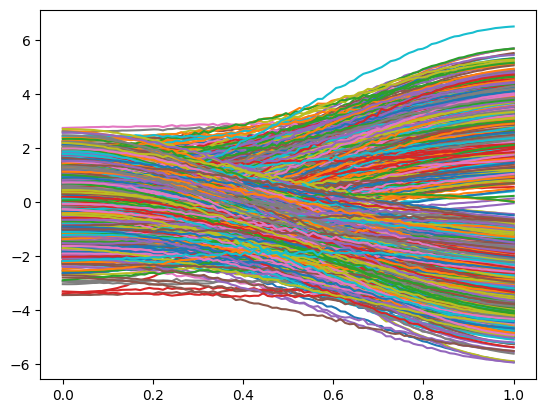

In [18]:
for i in range(N):
    plt.plot(t_N[:,i,0],X_f[:,i,0])

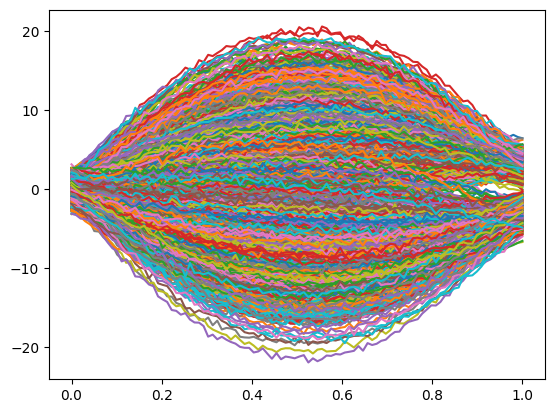

In [19]:
for i in range(N):
    plt.plot(t_N[:,i,0],X_f[:,i,1])

In [20]:
### learning u = k(x,t)###

ITERS = 20000
BATCH_SIZE = 32
LR = 1e-3

k = score_nn(n,16)
# init_weights(f)
k.train()
optimizer_k = torch.optim.Adam(k.parameters(), lr=LR)
scheduler_k = torch.optim.lr_scheduler.StepLR(optimizer_k, step_size=2000, gamma=0.99)

for i in range(ITERS):
    idx = torch.randperm(N)[:BATCH_SIZE]
    X_train = X_f[:,idx,:]
    t_train = t_N[:,idx,:]  
    u_train = u_f[:,idx,:]
    k_value = k.forward(X_train,t_train) 
    loss = nn.MSELoss()(k_value,u_train)
    
    optimizer_k.zero_grad()
    loss.backward()
    optimizer_k.step()
    scheduler_k.step()
    
    if  (i+1)==ITERS or (i+1)%100==0:
        k_value = k.forward(X_f,t_N)
        loss = ((k_value-u_f)*(k_value-u_f)).mean()
        
        print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

Iteration: 100/20000, loss = 285.937194824219
Iteration: 200/20000, loss = 234.284484863281
Iteration: 300/20000, loss = 226.932952880859
Iteration: 400/20000, loss = 220.077636718750
Iteration: 500/20000, loss = 213.058181762695
Iteration: 600/20000, loss = 204.640335083008
Iteration: 700/20000, loss = 194.982833862305
Iteration: 800/20000, loss = 182.435623168945
Iteration: 900/20000, loss = 170.991058349609
Iteration: 1000/20000, loss = 161.739074707031
Iteration: 1100/20000, loss = 155.535598754883
Iteration: 1200/20000, loss = 147.189895629883
Iteration: 1300/20000, loss = 142.581268310547
Iteration: 1400/20000, loss = 137.711105346680
Iteration: 1500/20000, loss = 133.383468627930
Iteration: 1600/20000, loss = 131.668075561523
Iteration: 1700/20000, loss = 127.667083740234
Iteration: 1800/20000, loss = 126.889007568359
Iteration: 1900/20000, loss = 124.267517089844
Iteration: 2000/20000, loss = 122.919410705566
Iteration: 2100/20000, loss = 122.372482299805
Iteration: 2200/20000,

In [21]:
N = 2000
T = 1000

t = torch.linspace(0,tf,T).repeat(N).reshape(N,T).T[:,:,None]
dt = tf/T

W_b = torch.zeros((T, N, m))
for i in range(T):
    W_b[i,:,:] = MultivariateNormal(torch.zeros(m), dt*torch.eye(m)).sample((N,))
W_b = torch.cat((torch.zeros((T,N,1)), W_b), dim=2)

X_b = torch.zeros(T,N,n)
X_b[0] = torch.randn(N,n)
#X_b[0] = X[0].clone()
for i in range(0,T-1):
    u_pred = k.forward(X_b[i,None,:,:],t[i,None,:,:])[0]
    
    X_b[i+1] = X_b[i] + (A @ X_b[i].T).T * dt + (B @ u_pred.T).T * dt + n_sigma * W_b[i]

In [17]:
### Learning y = f(x,t) ###

# ITERS = 20000
# BATCH_SIZE = 32
# LR = 1.5e-3

# f = score_nn(n,16)
# # init_weights(f)
# f.train()
# optimizer_f = torch.optim.Adam(f.parameters(), lr=LR)
# scheduler_f = torch.optim.lr_scheduler.StepLR(optimizer_f, step_size=1000, gamma=0.99)

# for i in range(ITERS):
#     idx = torch.randperm(N)[:BATCH_SIZE]
#     X_train = X_f[:,idx,:]
#     t_train = t_N[:,idx,:]  
#     Y_train = y[idx,:]
#     f_value = f.forward(X_train,t_train) 
#     loss = ((f_value-Y_train)*(f_value-Y_train)).mean()
    
#     optimizer_f.zero_grad()
#     loss.backward()
#     optimizer_f.step()
#     scheduler_f.step()
    
#     if  (i+1)==ITERS or (i+1)%100==0:
#         f_value = f.forward(X_f,t_N)
#         loss = ((f_value-y)*(f_value-y)).mean()
        
#         print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

In [18]:
# N = 2000
# T = 1000

# t = torch.linspace(0,tf,T).repeat(N).reshape(N,T).T[:,:,None]
# dt = tf/T

# W_b = torch.zeros((T, N, m))
# for i in range(T):
#     W_b[i,:,:] = MultivariateNormal(torch.zeros(m), dt*torch.eye(m)).sample((N,))
# W_b = torch.cat((torch.zeros((T,N,1)), W_b), dim=2)

# X_b = torch.zeros(T,N,n)
# X_b[0] = torch.randn(N,n)
# #X_b[0] = X[0].clone()
# for i in range(0,T-1):
#     y_pred = f.forward(X_b[i,None,:,:],t[i,None,:,:])[0]
#     # print(torch.inverse(torch.tensor([[(1-t[i,0,0])**3/3, (1-t[i,0,0])**2/2], [(1-t[i,0,0])**2/2, 1-t[i,0,0]]])))
#     u = (torch.tensor([[1 - t[i,0,0],1]]) @ torch.pinverse(torch.tensor([[(1-t[i,0,0])**3/3, (1-t[i,0,0])**2/2], [(1-t[i,0,0])**2/2, 1-t[i,0,0]]])) @ (y_pred - (torch.tensor([[1, 1-t[i,0,0]],[0, 1]]) @ X_b[i].T).T).T).T
#     # print(y_pred)
#     X_b[i+1] = X_b[i] + (A @ X_b[i].T).T * dt + (B @ u.T).T * dt + n_sigma * W_b[i]

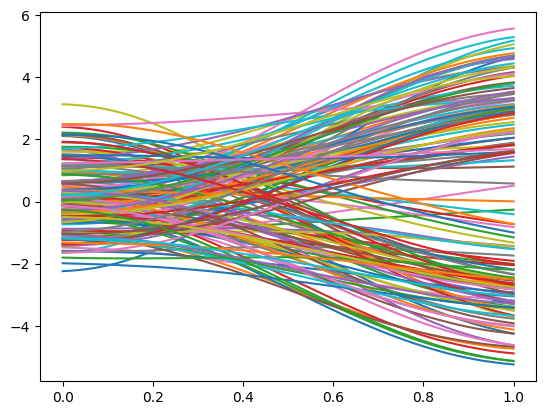

In [22]:
idx = torch.randperm(N)[:150]

for i in idx:
    plt.plot(t[:,i,0],X_b[:,i,0].detach().numpy())

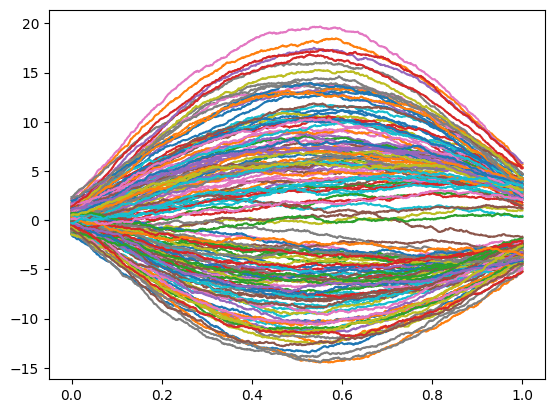

In [23]:
idx = torch.randperm(N)[:150]

for i in idx:
    plt.plot(t[:,i,0],X_b[:,i,1].detach().numpy())

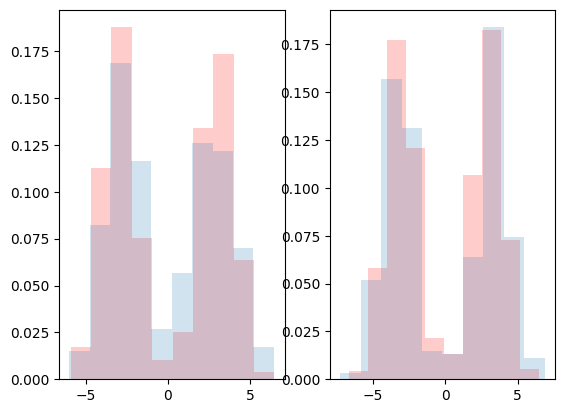

In [24]:
plt.figure()
plt.subplot(1,2,1)
plt.hist(y.numpy()[:,0],alpha=0.2, color='r',density=True)
plt.hist(X_b.detach().numpy()[-1,:,0],alpha=0.2, density=True)
plt.subplot(1,2,2)
plt.hist(y.numpy()[:,1],alpha=0.2, color='r',density=True)
plt.hist(X_b.detach().numpy()[-1,:,1],alpha=0.2, density=True)
plt.show()


In [25]:
print(X_b[-1,:,:].detach().mean(dim = 0))
print(X_b[-1,:,:].detach().std(dim = 0))

tensor([ 0.0395, -0.0444])
tensor([3.0702, 3.5202])
